In [26]:
# Add project root to path and import required modules
import sys; sys.path.append('../..')
import inflation, mesh, sheet_meshing
import numpy as np
import utils, py_newton_optimizer, benchmark
import visualization
from tri_mesh_viewer import TriMeshViewer, OffscreenTriMeshViewer
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [27]:
# Load mesh vertices/edges and fused points (internal non-inflating regions)
V, E = mesh.load_raw('../data/ForwardDesignA/hinge.obj')
fusedPts = list(np.loadtxt('../data/ForwardDesignA/fusehingev3.txt').reshape((-1, 2)))
holePts = []  # No holes in this example

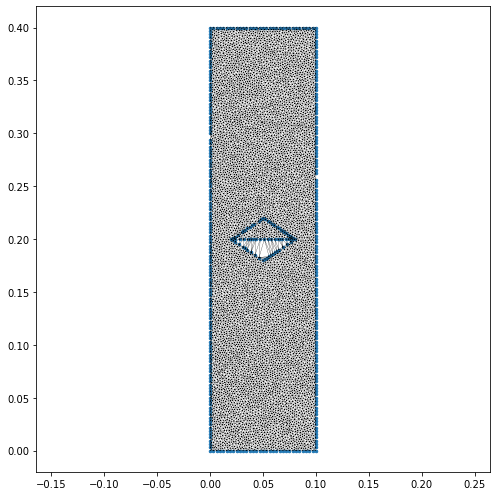

In [28]:
# Create the mesh for the inflatable sheet
m, iwv, iwbv = sheet_meshing.forward_design_mesh(
    V, E, fusedPts, holePts, np.prod(utils.bbox_dims(V)[0:2]) / 1e4
)

# Visualize the 2D mesh and highlight fused vertices
visualization.plot_2d_mesh(m, pointList=np.where(iwv)[0], width=7, height=7)

In [29]:
# Create the InflatableSheet object
isheet = inflation.InflatableSheet(m, iwv)

# Optionally set material properties if available
isheet.thickness = 0.00015         # 0.15 mm (TPU nylon 70D)
isheet.youngModulus = 2.5e8        # 250 MPa

In [30]:
# Define target points in 3D and find nearest mesh vertices for tracking
target_points = np.array([
    [0.05, 0.00, 0.0],
    [0.05, 0.20, 0.0],
    [0.05, 0.40, 0.0]# Export the deformed mesh as an OBJ file for further use (e.g., visualization in external tools)
])

# Get rest positions and find nearest actual vertices
V_rest = np.array([v.flatten() for v in isheet.restWallVertexPositions()])
tree = KDTree(V_rest)
tracked_indices = [tree.query(p)[1] for p in target_points]

# Store rest positions for displacement calculation
rest_positions = {idx: V_rest[idx] for idx in tracked_indices}

print("Tracked indices:", tracked_indices)
print("Tracked coordinates:", [V_rest[i] for i in tracked_indices])

Tracked indices: [362, 96, 153]
Tracked coordinates: [array([0.05, 0.  , 0.  ]), array([0.05125, 0.2    , 0.     ]), array([0.05, 0.4 , 0.  ])]


In [31]:
# Set up the on-screen viewer for interactive visualization
viewer = TriMeshViewer(isheet, width=768, height=640)
viewer.showWireframe(True)
viewer.show()

Renderer(camera=PerspectiveCamera(aspect=1.2, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [32]:
# Set up dictionary to store trajectory over time
trajectory = {idx: [] for idx in tracked_indices}
framerate = 5  # Save every 5 iterations

def cb(it):
    if it % framerate == 0:
        for idx in tracked_indices:
            pos = isheet.getDeformedVtxPosition(idx, 0).flatten()
            trajectory[idx].append(pos)
        viewer.update()  # Update on-screen viewer

# Set up optimizer options
opts = py_newton_optimizer.NewtonOptimizerOptions()
opts.useIdentityMetric = True
opts.beta = 1e-4
opts.gradTol = 1e-10
opts.niter = 200

# Set up simulation parameters
isheet.setUseTensionFieldEnergy(True)
isheet.setUseHessianProjectedEnergy(False)
isheet.pressure = 26e3  # Adjust as needed

benchmark.reset()
cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts, callback=cb)
benchmark.report()

InflatableSheet setVars	0.00311089	1
Newton iterations	126.717	1
    InflatableSheet energy	0.00103498	1
    InflatableSheet gradient	0.00112605	1
    Newton iterate	126.713	200
        Backtracking	1.11161	200
            InflatableSheet energy	0.20756	320
            InflatableSheet setVars	0.887241	320
        Compute descent direction	122.192	200
            newton_step	122.191	200
                Newton solve	116.309	279
                    CHOLMOD Numeric Factorize	113.639	278
                    Solve	2.1083	201
                        CHOLMOD Backsub	1.91862	200
                        CHOLMOD Numeric Factorize	0.0199139	1
                        CHOLMOD Symbolic Factorize	0.142193	1
                hessEval	5.80687	200
                largestMagnitudeEigenvalue	0.0353079	2
        Preamble	3.33778	200
            Callback	2.88096	200
            InflatableSheet energy	0.12709	200
            InflatableSheet gradient	0.28192	200
Full time	126.745


In [33]:
# Re-initialize the sheet if you want a fresh start for the video
isheet = inflation.InflatableSheet(m, iwv)
isheet.thickness = 0.00015
isheet.youngModulus = 2.5e8
isheet.setUseTensionFieldEnergy(True)
isheet.setUseHessianProjectedEnergy(False)
isheet.pressure = 26e3

opts.niter = 500  # or as needed

# Set up offscreen viewer for video recording
oview = OffscreenTriMeshViewer(isheet, width=768, height=640, wireframe=True)

# Tracking for video run
trajectory = {idx: [] for idx in tracked_indices}
def cb_video(it):
    if it % framerate == 0:
        for idx in tracked_indices:
            pos = isheet.getDeformedVtxPosition(idx, 0).flatten()
            trajectory[idx].append(pos)
        oview.update()

benchmark.reset()
oview.recordStart('inflation_videoA.mp4')
cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts, callback=cb_video)
benchmark.report()
oview.recordStop()

InflatableSheet setVars	0.0437312	1
Newton iterations	132.918	1
    InflatableSheet energy	0.000520945	1
    Newton iterate	132.916	223
        Backtracking	1.51491	222
            InflatableSheet energy	0.269294	380
            InflatableSheet setVars	1.21995	380
        Compute descent direction	124.479	222
            newton_step	124.478	222
                Newton solve	117.754	288
                    CHOLMOD Numeric Factorize	114.621	287
                    Solve	2.572	223
                        CHOLMOD Backsub	2.38054	222
                        CHOLMOD Numeric Factorize	0.022135	1
                        CHOLMOD Symbolic Factorize	0.133251	1
                hessEval	6.65149	222
                largestMagnitudeEigenvalue	0.0372968	2
        Preamble	6.81987	223
            Callback	6.27378	223
            InflatableSheet energy	0.153268	223
            InflatableSheet gradient	0.324027	223
Full time	133


In [34]:
# Export the deformed mesh as an OBJ file for further use (e.g., visualization in external tools)
def write_obj(path, V, F):
    with open(path, "w") as f:
        for v in V:
            f.write("v {:.6f} {:.6f} {:.6f}\n".format(*v))
        for face in F:
            f.write("f {} {} {}\n".format(*(face + 1)))  # OBJ is 1-indexed

# Get the deformed geometry from the sheet
V_raw, F_raw, *_ = isheet.visualizationGeometry()
V = np.array([v.flatten() for v in V_raw], dtype=np.float64)
F = np.array([f for f in F_raw], dtype=np.int32)
write_obj("inflated_meshA.obj", V, F)

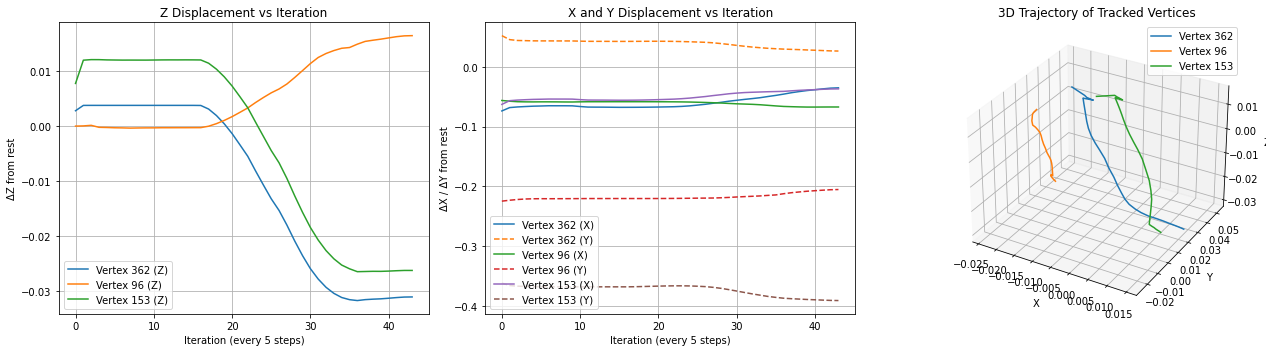

In [35]:
# Plot Z displacement, X/Y displacement, and 3D trajectory for tracked vertices
fig = plt.figure(figsize=(18, 5))

# Z Displacement
ax1 = fig.add_subplot(1, 3, 1)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        z_disp = traj[:, 2] - rest_positions[idx][2]
        ax1.plot(range(len(traj)), z_disp, label=f"Vertex {idx} (Z)")
ax1.set_title("Z Displacement vs Iteration")
ax1.set_xlabel(f"Iteration (every {framerate} steps)")
ax1.set_ylabel("ΔZ from rest")
ax1.grid(True)
ax1.legend()

# X and Y Displacement
ax2 = fig.add_subplot(1, 3, 2)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        x_disp = traj[:, 0] - rest_positions[idx][0]
        y_disp = traj[:, 1] - rest_positions[idx][1]
        ax2.plot(range(len(traj)), x_disp, label=f"Vertex {idx} (X)")
        ax2.plot(range(len(traj)), y_disp, linestyle='--', label=f"Vertex {idx} (Y)")
ax2.set_title("X and Y Displacement vs Iteration")
ax2.set_xlabel(f"Iteration (every {framerate} steps)")
ax2.set_ylabel("ΔX / ΔY from rest")
ax2.grid(True)
ax2.legend()

# 3D Trajectory
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        ax3.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"Vertex {idx}")
ax3.set_title("3D Trajectory of Tracked Vertices")
ax3.set_xlabel("X")
ax3.set_ylabel("Y")
ax3.set_zlabel("Z")
ax3.legend()

plt.tight_layout()
plt.show()

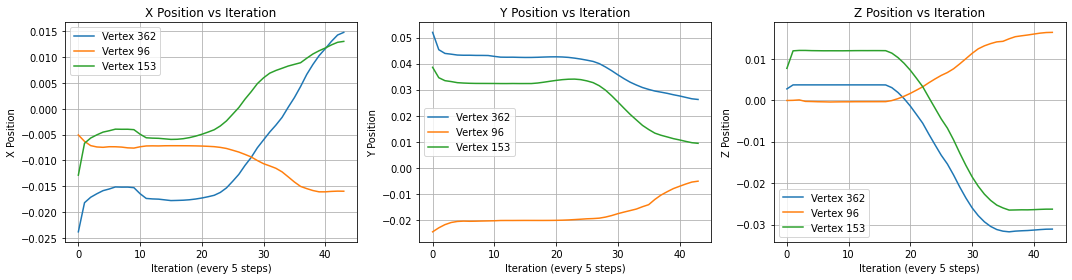

In [36]:
# Plot absolute X, Y, Z positions vs iteration for each tracked vertex
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] <= 1:
        continue
    iterations = range(len(traj))
    axs[0].plot(iterations, traj[:, 0], label=f"Vertex {idx}")
    axs[1].plot(iterations, traj[:, 1], label=f"Vertex {idx}")
    axs[2].plot(iterations, traj[:, 2], label=f"Vertex {idx}")

# X
axs[0].set_title("X Position vs Iteration")
axs[0].set_xlabel(f"Iteration (every {framerate} steps)")
axs[0].set_ylabel("X Position")
axs[0].grid(True)
axs[0].legend()

# Y
axs[1].set_title("Y Position vs Iteration")
axs[1].set_xlabel(f"Iteration (every {framerate} steps)")
axs[1].set_ylabel("Y Position")
axs[1].grid(True)
axs[1].legend()

# Z
axs[2].set_title("Z Position vs Iteration")
axs[2].set_xlabel(f"Iteration (every {framerate} steps)")
axs[2].set_ylabel("Z Position")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

In [39]:
print("Target points:")
for p in target_points:
    print(p)
print("\nTracked indices and their rest positions:")
for idx in tracked_indices:
    print(f"Index: {idx}, Rest position: {rest_positions[idx]}")
    print(f"Distance to target: {np.linalg.norm(rest_positions[idx] - target_points[tracked_indices.index(idx)])}")

Target points:
[0.05 0.   0.  ]
[0.05 0.2  0.  ]
[0.05 0.4  0.  ]

Tracked indices and their rest positions:
Index: 362, Rest position: [0.05 0.   0.  ]
Distance to target: 0.0
Index: 96, Rest position: [0.05125 0.2     0.     ]
Distance to target: 0.0012500000000000011
Index: 153, Rest position: [0.05 0.4  0.  ]
Distance to target: 0.0


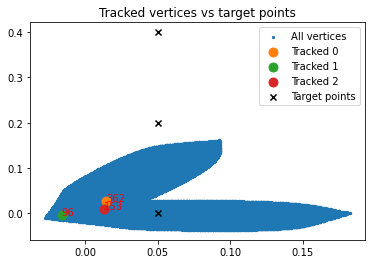

In [40]:
import matplotlib.pyplot as plt

V2d = np.array([v[:2] for v in V])  # If V is Nx3
plt.scatter(V2d[:,0], V2d[:,1], s=5, label='All vertices')
for i, idx in enumerate(tracked_indices):
    plt.scatter(V2d[idx,0], V2d[idx,1], s=80, label=f'Tracked {i}')
    plt.text(V2d[idx,0], V2d[idx,1], str(idx), color='red')
plt.scatter([p[0] for p in target_points], [p[1] for p in target_points], marker='x', color='k', label='Target points')
plt.legend()
plt.title("Tracked vertices vs target points")
plt.show()